In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

anime = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Recommendation_systems/anime/anime.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Recommendation_systems/anime/rating.csv.zip")

In [ ]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
ratings.isnull().sum()


,0
user_id,0
anime_id,0
rating,0


In [ ]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [ ]:
print(f"Anime data: {anime.describe}")
print(f"Ratings data: {ratings.describe}")

Anime data: <bound method NDFrame.describe of        anime_id                                               name  \
0         32281                                     Kimi no Na wa.   
1          5114                   Fullmetal Alchemist: Brotherhood   
2         28977                                           Gintama°   
3          9253                                        Steins;Gate   
4          9969                                      Gintama&#039;   
...         ...                                                ...   
12289      9316       Toushindai My Lover: Minami tai Mecha-Minami   
12290      5543                                        Under World   
12291      5621                     Violence Gekiga David no Hoshi   
12292      6133  Violence Gekiga Shin David no Hoshi: Inma Dens...   
12293     26081                   Yasuji no Pornorama: Yacchimae!!   

                                                   genre   type episodes  \
0                   Drama, Romance, S

In [ ]:
print(f"Anime data: {anime.info}")
print(f"Ratings data: {ratings.info}")

Anime data: <bound method DataFrame.info of        anime_id                                               name  \
0         32281                                     Kimi no Na wa.   
1          5114                   Fullmetal Alchemist: Brotherhood   
2         28977                                           Gintama°   
3          9253                                        Steins;Gate   
4          9969                                      Gintama&#039;   
...         ...                                                ...   
12289      9316       Toushindai My Lover: Minami tai Mecha-Minami   
12290      5543                                        Under World   
12291      5621                     Violence Gekiga David no Hoshi   
12292      6133  Violence Gekiga Shin David no Hoshi: Inma Dens...   
12293     26081                   Yasuji no Pornorama: Yacchimae!!   

                                                   genre   type episodes  \
0                   Drama, Romance, Sch

In [ ]:
print(f"Anime data: {anime.shape}")
print(f"Ratings data: {ratings.shape}")

Anime data: (12294, 7)
Ratings data: (7813737, 3)


# Remove unrated animes and numeric NA data, and replace Non-numeric NA data

In [2]:
ratings = ratings[ratings['rating'] != -1]

anime = anime.drop(list(anime.loc[anime['rating'].isnull() == True].index), axis=0) ##.index and axis = 0  to ensure it only works on the one column
anime = anime.fillna('Unknown') ## replaces any blanks in non-numeric data
anime =  anime.reset_index(drop = True)
anime.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


# Some stats work

In [ ]:
print(len(anime['genre'].unique()))
print(len(anime))

3230
12064


In [ ]:
print(anime['type'].unique())

['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']


PearsonRResult(statistic=np.float64(0.08954596538677491), pvalue=np.float64(1.0644441956652061e-14))


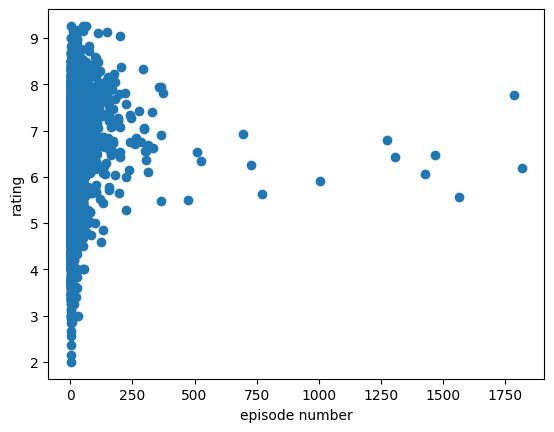

In [ ]:
## do certain anime lengths do better? -- tv show only
anime_no_film =  anime[anime['type'].isin(['TV','OVA', 'ONA'])]
## there are some with unknown episode numbers that need removing
anime_no_film = anime_no_film[anime_no_film['episodes'] != 'Unknown']
anime_no_film['episodes'] = anime_no_film['episodes'].astype(int)
print(pearsonr(anime_no_film['episodes'], anime_no_film['rating']))

mpl.scatter(anime_no_film['episodes'], anime_no_film['rating'])
mpl.xlabel('episode number')
mpl.ylabel('rating')
mpl.show()
 ## while the relationship is signif it more seems that no longer anime is bad rather than longer animes are
 # better overall

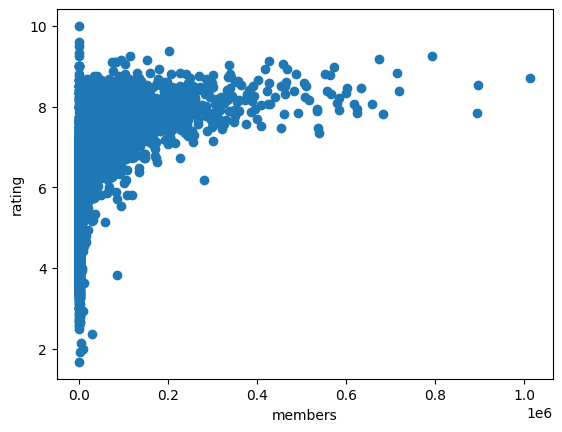

PearsonRResult(statistic=np.float64(0.3879794585003164), pvalue=np.float64(0.0))


In [ ]:
## want to look at genres but theres so many overlapping
## do members predict rating?
mpl.scatter(anime['members'], anime['rating'])
mpl.xlabel('members')
mpl.ylabel('rating')
mpl.show()
print(pearsonr(anime['members'], anime['rating']))
## p = 0 so it definitely does!

#Reducing the size of the dataset for sampling

In [3]:
## reduce rating based on User ID
# drop duplicates
ratings_sample = ratings['user_id'].drop_duplicates().sample(n=10000, random_state= 40).values
# filter the data based on if user id is present
filtered_ratings = ratings[ratings['user_id'].isin(ratings_sample)]


In [5]:
## convert to correct matrix format
# cannot use these for the matrix just yet though -- needs to give numbers to users
## dictionary method used
User_id = {user: id for id, user in enumerate(filtered_ratings['user_id'].unique())}
Anime_id = {anime: id for id, anime in enumerate(filtered_ratings['anime_id'].unique())}


## check if this is in proper int format
rows = filtered_ratings['user_id'].map(User_id).astype(np.int64).values
cols = filtered_ratings['anime_id'].map(Anime_id).astype(np.int64).values
data = filtered_ratings['rating'].astype(np.float64).values
### this has mapped the rows and columns and added the ratings as floats

## need the csr matrix (compressed sparse row) in a tuple format
sparse_matrix = csr_matrix((data, (rows, cols)))
print(sparse_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 919634 stored elements and shape (10000, 8063)>
  Coords	Values
  (0, 0)	7.0
  (0, 1)	10.0
  (0, 2)	9.0
  (0, 3)	9.0
  (0, 4)	7.0
  (0, 5)	8.0
  (0, 6)	7.0
  (0, 7)	8.0
  (0, 8)	8.0
  (0, 9)	8.0
  (0, 10)	7.0
  (0, 11)	9.0
  (0, 12)	9.0
  (0, 13)	9.0
  (0, 14)	7.0
  (0, 15)	8.0
  (0, 16)	8.0
  (0, 17)	8.0
  (0, 18)	9.0
  (0, 19)	9.0
  (0, 20)	8.0
  (0, 21)	8.0
  (0, 22)	8.0
  (0, 23)	9.0
  (0, 24)	7.0
  :	:
  (9999, 542)	6.0
  (9999, 594)	8.0
  (9999, 670)	8.0
  (9999, 675)	7.0
  (9999, 677)	8.0
  (9999, 687)	8.0
  (9999, 692)	7.0
  (9999, 703)	9.0
  (9999, 834)	7.0
  (9999, 836)	10.0
  (9999, 872)	6.0
  (9999, 892)	8.0
  (9999, 893)	6.0
  (9999, 921)	7.0
  (9999, 955)	8.0
  (9999, 1008)	7.0
  (9999, 1011)	7.0
  (9999, 1017)	8.0
  (9999, 1071)	6.0
  (9999, 1670)	5.0
  (9999, 1671)	5.0
  (9999, 1856)	8.0
  (9999, 1899)	8.0
  (9999, 2206)	10.0
  (9999, 3365)	7.0


#Training the **KNN** model


In [9]:
KNN = NearestNeighbors(metric='cosine', algorithm = 'brute', n_neighbors = 20)
KNN.fit(sparse_matrix.tocsr())

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [10]:
## method to pick up random users
# could use 2 methods
# making random user rec
random_user = np.random.randint(0, sparse_matrix.shape[0])
user_vector = sparse_matrix.getrow(random_user).toarray().reshape(1,-1)


In [11]:
## let's find similar users to this
distances, indices = KNN.kneighbors(user_vector, n_neighbors = 20)
similar_users = indices.flatten()

In [12]:
## get content details based on similar users
## based on Anime_id
random_user_id = list(User_id.keys())[random_user]
user_anime = set(filtered_ratings[filtered_ratings['user_id'] == random_user_id]['anime_id'])# set deletes duplicates
## will run until neighbour value is met

In [15]:
recs = set() ##needs to be a set as list doesn't have an update function
for user in similar_users:
  similar_user_id =  list(User_id.keys())[user]
  recs.update(filtered_ratings[filtered_ratings['user_id'] == similar_user_id]['anime_id'].values)

recs.difference_update(user_anime) ## update not append as it can add multiple values at once unlike append


In [18]:
## display suggested recs
rec_names = anime[anime['anime_id'].isin(recs)]['name'].head(20).tolist() ## fetches results
print('Anime recommendations:')

for i, anime in enumerate(rec_names):
  print(f'{i+1}. {anime}')

## Will need to re-run the file in to redo this if wanted

TypeError: string indices must be integers, not 'str'